In [ ]:
# MNIST experiment in NGSpice and Nengo

In [1]:
!pip install nengo
!pip install numpy
!pip install sklearn
!pip install  matplotlib
!pip install pyspice
!sudo add-apt-repository ppa:kicad/kicad-5.1-releases -y
!sudo apt-get update
!sudo apt-get install libngspice-kicad

     |████████████████████████████████| 532kB 5.5MB/s 
     |████████████████████████████████| 153kB 5.9MB/s 
     |████████████████████████████████| 276kB 28.9MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=8edd62c9f6fb3f5aeb86f43158cb86cc969a46e00686cb0767c36e8ff877db15
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built PyYAML
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hi

In [2]:
# Load the library file

from google.colab import files
uploaded =  files.upload() #upload the 180nm.lib file here

Saving 180nm.lib to 180nm.lib


In [3]:
import nengo
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#fetch data
mnist = sklearn.datasets.fetch_openml('mnist_784')

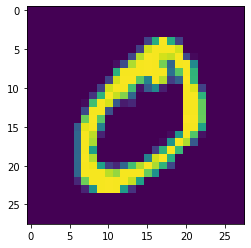

In [5]:
## view data
sample = 1
image = mnist['data'][sample]
image = image.reshape(28,28)
# plot the sample
fig = plt.figure
plt.imshow(image)
plt.show()


In [6]:
## data preprocessing
x = mnist['data'].astype(float)-128
x = x/np.linalg.norm(x, axis=1)[:,None]
       
y = mnist['target']
y = np.eye(10)[y.astype(int)]*2-1
y = y/np.linalg.norm(y, axis=1)[:,None]

order = np.arange(len(x))
np.random.shuffle(order)
x = x[order]
y = y[order]

In [7]:
#parameters

n_training=5000
n_testing=100

n_neurons=50
synapse=0.02
t_image=0.5
dt = 0.001

In [8]:
neuron_model = '''
.subckt my_neuron Vmem out cvar=100p vsupply=1.8 vtau=0.4 vthr=0.2 vb=1

V1 Vdd 0 {vsupply}
V6 Vtau 0 {vtau}
V2 Vthr 0 {vthr}
V3 Vb1 0 {vb}
C1 Vmem 0 {cvar}


M5 N001 N001 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
M6 N002 N001 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
M8 N001 Vmem N004 N004 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M9 N002 Vthr N004 N004 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M10 N004 Vb1 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
Mreset Vmem out 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M7 N003 N002 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M18 out N003 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M19 N003 N002 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
M20 out N003 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
Mleak Vmem Vtau 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2


.ends my_neuron
'''

In [9]:
def create_neuron_netlist(N):
    # N is the number of neurons
    netlist = ''
    for i in range(N):
        netlist += 'x'+str(i)+' Vmem'+str(i)+' out'+str(i)+' my_neuron vsupply={vsource} cvar=150p vthr=0.25 \n'
        netlist += 'Rload'+str(i)+' out'+str(i)+ ' 0 100k\n'
    return netlist

In [ ]:
def pwl_conv(signal):
    # signal should be a list of lists where wach sublist has this form [time_value, current_value]
    pwl_string = ''
    for i in signal:
        pwl_string += str(i[0]) + ' ' + str(i[1]) + ' '
    return pwl_string

In [10]:
## nengo and ngspice
model = nengo.Network()
with model:
    def stim_func(t, data=x[n_training:]):
        index = int(t / t_image)
        return data[index % len(data)]
    
    def result_func(t, raw, correct=y[n_training:]):
                index = int((t-dt) / t_image)
                c = np.argmax(correct[index])
                r = np.argmax(raw)
                return np.hstack([raw, c, r])
    
    
    stim = nengo.Node(stim_func)
   
    ens = nengo.Ensemble(n_neurons = n_neurons, 
                         dimensions=784,
                         intercepts=nengo.dists.CosineSimilarity(784+2))
    
    nengo.Connection(stim, ens, synapse=None)


    result = nengo.Node(result_func, size_in=10)
    
    
    nengo.Connection(ens, result, 
                         eval_points=x[:n_training], 
                         function=y[:n_training],
                         solver=nengo.solvers.LstsqL2(reg=0.1),
                         synapse=synapse)
    output = nengo.Probe(result)

In [13]:
with nengo.Simulator(model) as sim:  # Create the simulator
    T = n_testing * t_image
    sim.run(T)  

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

0.49


(0.0, 10.0)

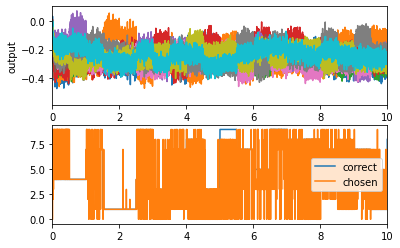

In [14]:
correct = sim.data[output][:,10].astype(int)
result = sim.data[output][:,11].astype(int)

confusion = np.zeros((10,10), dtype=int)
count = np.zeros(10, dtype=int)

times = sim.trange()

for i in range(n_testing):
    t = (i + 1) * t_image
    index = np.argmax(times >= t) - 1
    count[correct[index]] += 1
    confusion[correct[index],result[index]] += 1
score = sum(confusion[i, i] for i in range(10)) / float(n_testing)
print(score)

plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[output][:,:10])
plt.xlim(0, t_image * min(n_testing, 20))
plt.ylabel('output')
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[output][:,10:])
plt.legend(['correct', 'chosen'], loc='best')
plt.xlim(0, t_image * min(n_testing, 20))